In [193]:
import gower
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns
from sklearn.metrics import rand_score, adjusted_rand_score
import sys
import os
## import tSNE

In [194]:
## import custom scripts
sys.path.append(os.path.abspath(os.path.join('scripts')))
import preprocessing
import autoencoder_detection
import isolation_forest_detection
import lof_detection
import knn_detection
import dbscan_detection
import pca_detection
import utils

importlib.reload(utils)
importlib.reload(lof_detection)
importlib.reload(autoencoder_detection)
importlib.reload(preprocessing)
importlib.reload(isolation_forest_detection)
importlib.reload(knn_detection)
importlib.reload(dbscan_detection)
importlib.reload(pca_detection)

<module 'pca_detection' from '/home/ronin/Dev/notebooks/machinelearningformodeling/unsupervised/project/scripts/pca_detection.py'>

In [195]:
df = preprocessing.load_dataset()
dm = gower.gower_matrix(df)

In [196]:
## validation dataset
# df = pd.read_csv('data/data2_preprocessed.csv')
# true_labels =  df.iloc[:,-1]
# df = df.iloc[:, :-1]
# dm = gower.gower_matrix(df)
# np.sum(true_labels == -1) 371

In [197]:
pca_indices = pca_detection.main(distance_matrix=dm)
pd.DataFrame(pca_indices).value_counts()

PCA: explained variation per principal component: [0.55993 0.27381 0.06283 0.02981 0.02188 0.01664 0.01021 0.00602]


 0    6829
-1     371
Name: count, dtype: int64

In [137]:
dbscan_indices = dbscan_detection.main(distance_matrix=dm)
pd.DataFrame(dbscan_indices).value_counts()

 0    6862
-1     338
Name: count, dtype: int64

In [138]:
# Importing the dataset
lof_indices = lof_detection.main(distance_matrix=dm)
pd.DataFrame(lof_indices).value_counts()

 0    6840
-1     360
Name: count, dtype: int64

In [139]:
autoencoder_indices = np.array(autoencoder_detection.main(dataframe=df))
#print(adjusted_rand_score(isolation_forest_indices, autoencoder_indices))
pd.DataFrame(autoencoder_indices).value_counts()

Epoch [1/50], Loss: 0.1344, LR: 0.01
Epoch [11/50], Loss: 0.0222, LR: 0.005
Epoch [21/50], Loss: 0.0115, LR: 0.0025
Epoch [31/50], Loss: 0.0046, LR: 0.00125
Epoch [41/50], Loss: 0.0080, LR: 0.000625
Training complete
number of outliers is: 382


 0    6818
-1     382
Name: count, dtype: int64

In [140]:
isolation_forest_indices = pd.DataFrame(isolation_forest_detection.main(dataframe=df)).replace({1:0}).to_numpy()[:,0]
pd.DataFrame(isolation_forest_indices).value_counts()

 0    6840
-1     360
Name: count, dtype: int64

In [141]:
knn_indices = np.array(knn_detection.main(distance_matrix=dm))
pd.DataFrame(knn_indices).value_counts()

knee = 0.05163099989295006


 0    6882
-1     318
Name: count, dtype: int64

In [142]:
# this array will contain the number of methods that classified the instance as an outlier
# in [0, 6]
tot_indices = (lof_indices + 
                autoencoder_indices +  
                isolation_forest_indices + 
                knn_indices + 
                dbscan_indices +
                pca_indices)
tot_indices = -1 * tot_indices

In [143]:
# we are creating a dataframe that will be used for the assessment of the results
comparison = pd.DataFrame()
comparison['tot_indices'] = tot_indices
comparison['lof_indices'] = lof_indices
comparison['autoencoder_indices'] = autoencoder_indices
comparison['isolation_forest_indices'] = isolation_forest_indices
comparison['knn_indices'] = knn_indices
comparison['dbscan_indices'] = dbscan_indices
comparison['pca_indices'] = pca_indices
(np.sum(comparison, axis = 0) * -1).iloc[1:]

lof_indices                 360
autoencoder_indices         382
isolation_forest_indices    360
knn_indices                 318
dbscan_indices              338
pca_indices                 371
dtype: int64

In [144]:
# we are calculating the probabilities for each point to be an outlier, using our sigmoid function
outl_probs = list(map(utils.sigmoid_to_prob(k=6), tot_indices))
# outl_probs = list(map(lambda x: x/6, outl_probs))
pd.DataFrame(outl_probs, columns=["Probability"]).value_counts().sort_index()

Probability
0.00           6544
0.08            190
0.24             98
0.50             57
0.76             83
0.92            128
1.00            100
Name: count, dtype: int64

In [145]:
np.save('results.npy', outl_probs)
pd.DataFrame(outl_probs, columns=["probability"]).to_csv('results.csv', index=False)

In [149]:
pd.read_csv('results.csv').head()

,probability
0,0.92
1,0.00
2,0.00
3,0.00
4,0.00


In [148]:
comparison.iloc[1077,:]

tot_indices                 6
lof_indices                -1
autoencoder_indices        -1
isolation_forest_indices   -1
knn_indices                -1
dbscan_indices             -1
pca_indices                -1
Name: 1077, dtype: int64

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.025s...
[t-SNE] Computed neighbors for 7200 samples in 0.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.399696
[t-SNE] KL divergence after 1000 iterations: 0.983499


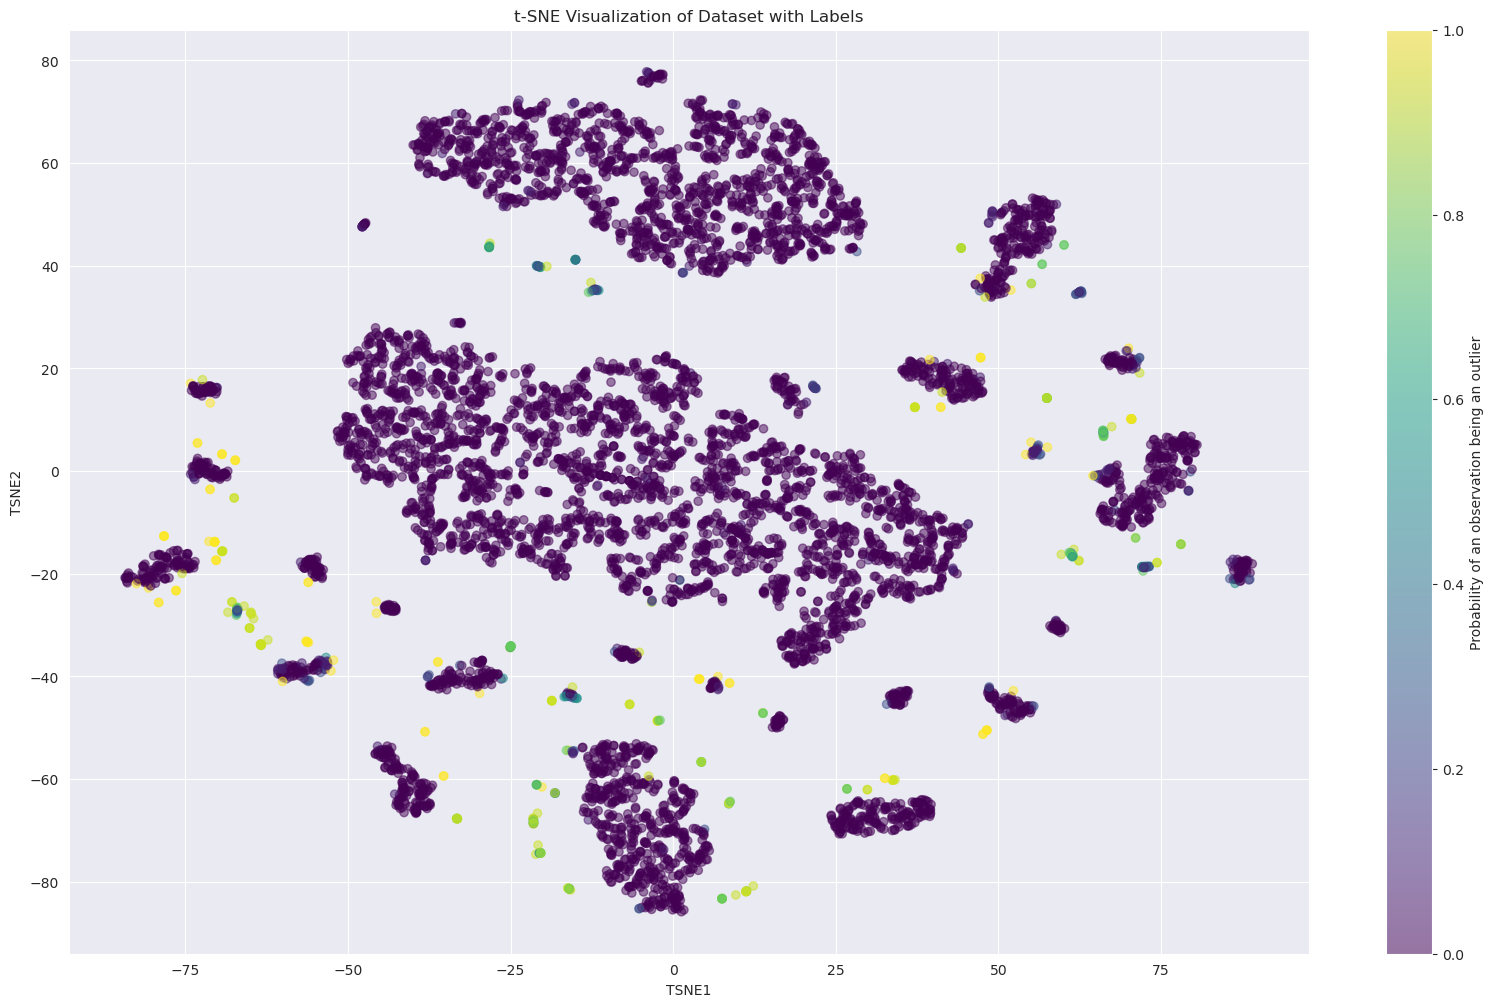

In [20]:
utils.plot_TSNE_2(dist_matrix= dm, labels=outl_probs)

In [150]:
non_out = tot_indices < 5

In [151]:
out = tot_indices >= 5

In [152]:
a = np.abs(np.sum(df[non_out].iloc[:,utils.binary_indices] - 1, axis=1)).describe()
b = np.abs(np.sum(df[out].iloc[:,utils.binary_indices] - 1, axis=1)).describe()
df_falses = pd.concat([a, b], axis=1)
df_falses.columns = ['non_outliers', 'outliers']
df_falses

,non_outliers,outliers
count,6972.000000,228.000000
mean,0.712134,2.627193
std,0.683143,0.754754
min,0.000000,0.000000
25%,0.000000,2.000000
50%,1.000000,3.000000
75%,1.000000,3.000000
max,3.000000,5.000000


In [217]:
## we define as ensemble method the one that classifies an instance as an outlier if at least 5 methods classify it as an outlier
list_of_indices =   [lof_indices,
                     autoencoder_indices ,
                    isolation_forest_indices,
                    knn_indices,
                    dbscan_indices,
                    pca_indices,
                    (-1 * (np.array(tot_indices) >= 5))]
                    #true_labels.to_numpy()]
method_names =  ["lof",
                 "autoencoder",
                "iso_forest",
                "knn",
                "dbscan",
                "pca",
                 "Ensemble"]
                 #"true_labels"]

In [232]:
jaccard = utils.jaccard_index(-1) ## returns a callable function

def compute_indices(label_lists):
    n = len(label_lists)
    indices = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n): # swap with (i,n) if it is symmetric
            #score = adjusted_rand_score(label_lists[i], label_lists[j])
            #score = rand_score(label_lists[i], label_lists[j])
            score = jaccard(label_lists[i], label_lists[j])
            #score = agreement_index(label_lists[i], label_lists[j])
            indices[i, j] = score
            indices[j, i] = score
    return indices

def plot_heatmap(matrix, labels):
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.7)  # Increase the font scale
    ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", vmin=0)
    ax.set_title('Jaccard similarity heatmap', fontsize=20)  # Increase title font size
    plt.tight_layout()
    plt.savefig('jaccard_similarity.png')
    plt.show()


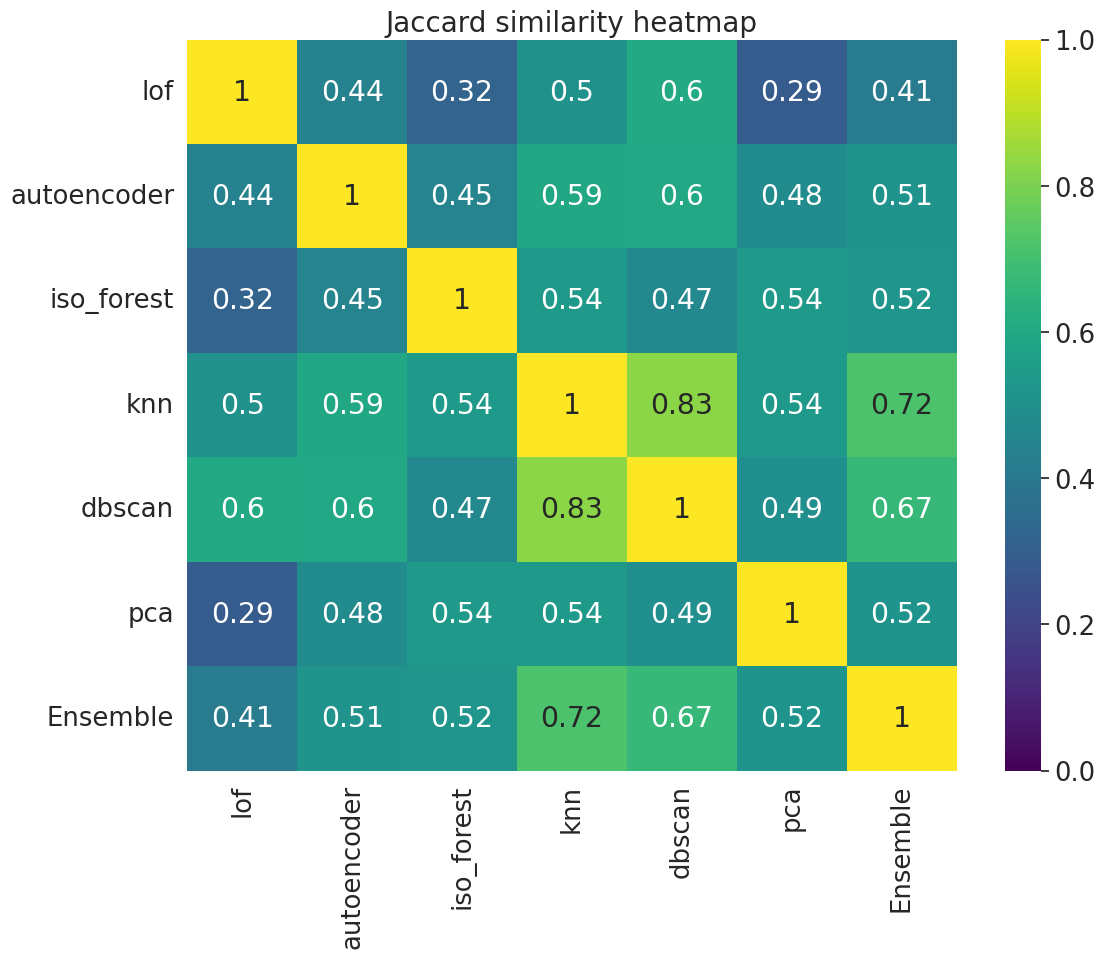

In [233]:
plot_heatmap(compute_indices(list_of_indices), labels=method_names)

In [234]:
np.sum(tot_indices >= 5)

228

In [235]:
np.max(dm / np.max(dm))

1.0